## Importing Dependencies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys

In [2]:
sys.path.append('/Users/kanghong/Documents/Developer/Google-Capstone/cyclist-case-study/src/')

from data_cleaning import nullProportions, verifyConcat, format_latlon, time_to_minutes, extract_hour, extract_month, extract_weekday
from geocode import calculate_distance
from trip_analysis import calculateTimeDiff,season_match,filter_unfeasible_rides
from data_viz import generate_hist_plot, generate_prop_plot, generate_pie, generate_stack_hist, plot_pivot_table
from geocode import generate_heatmap

## Data Cleaning & Transformation

In [3]:
### --- Reading 12 CSVs ---
may_2024 = pd.read_csv('/Users/kanghong/Documents/Developer/Google-Capstone/cyclist-case-study/data/raw/202405-divvy-tripdata.csv')
jun_2024 = pd.read_csv('/Users/kanghong/Documents/Developer/Google-Capstone/cyclist-case-study/data/raw/202406-divvy-tripdata.csv')
jul_2024 = pd.read_csv('/Users/kanghong/Documents/Developer/Google-Capstone/cyclist-case-study/data/raw/202407-divvy-tripdata.csv')
aug_2024 = pd.read_csv('/Users/kanghong/Documents/Developer/Google-Capstone/cyclist-case-study/data/raw/202408-divvy-tripdata.csv')
sep_2024 = pd.read_csv('/Users/kanghong/Documents/Developer/Google-Capstone/cyclist-case-study/data/raw/202409-divvy-tripdata.csv')
oct_2024 = pd.read_csv('/Users/kanghong/Documents/Developer/Google-Capstone/cyclist-case-study/data/raw/202410-divvy-tripdata.csv')
nov_2024 = pd.read_csv('/Users/kanghong/Documents/Developer/Google-Capstone/cyclist-case-study/data/raw/202411-divvy-tripdata.csv')
dec_2024 = pd.read_csv('/Users/kanghong/Documents/Developer/Google-Capstone/cyclist-case-study/data/raw/202412-divvy-tripdata.csv')
jan_2025 = pd.read_csv('/Users/kanghong/Documents/Developer/Google-Capstone/cyclist-case-study/data/raw/202501-divvy-tripdata.csv')
feb_2025 = pd.read_csv('/Users/kanghong/Documents/Developer/Google-Capstone/cyclist-case-study/data/raw/202502-divvy-tripdata.csv')
mar_2025 = pd.read_csv('/Users/kanghong/Documents/Developer/Google-Capstone/cyclist-case-study/data/raw/202503-divvy-tripdata.csv')
apr_2025 = pd.read_csv('/Users/kanghong/Documents/Developer/Google-Capstone/cyclist-case-study/data/raw/202504-divvy-tripdata.csv')

In [4]:
### --- Concatenating Datasets ---
past_year_data = [may_2024, jun_2024, jul_2024, aug_2024, sep_2024, oct_2024, nov_2024, dec_2024, jan_2025, feb_2025, mar_2025, apr_2025]

cyclistic_past_year = pd.concat(past_year_data, ignore_index=True)

cyclistic_past_year.head(5)

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,7D9F0CE9EC2A1297,classic_bike,2024-05-25 15:52:42,2024-05-25 16:11:50,Streeter Dr & Grand Ave,13022,Clark St & Elm St,TA1307000039,41.892278,-87.612043,41.902973,-87.631280,casual
1,02EC47687411416F,classic_bike,2024-05-14 15:11:51,2024-05-14 15:22:00,Sheridan Rd & Greenleaf Ave,KA1504000159,Sheridan Rd & Loyola Ave,RP-009,42.010587,-87.662412,42.001044,-87.661198,casual
2,101370FB2D3402BE,classic_bike,2024-05-30 17:46:04,2024-05-30 18:09:16,Streeter Dr & Grand Ave,13022,Wabash Ave & 9th St,TA1309000010,41.892278,-87.612043,41.870769,-87.625734,member
3,E97E396331ED6913,electric_bike,2024-05-17 20:21:54,2024-05-17 20:40:32,Streeter Dr & Grand Ave,13022,Sheffield Ave & Wellington Ave,TA1307000052,41.892270,-87.611946,41.936253,-87.652662,member
4,674EDE311C543165,classic_bike,2024-05-22 18:52:20,2024-05-22 18:59:04,Larrabee St & Division St,KA1504000079,Clark St & Elm St,TA1307000039,41.903486,-87.643353,41.902973,-87.631280,casual


In [5]:
### --- Ensuring Concatenation was accurate --- 
verifyConcat(past_year_data, cyclistic_past_year)

True

In [6]:
### --- Checking NULLs ---
nullProportions(cyclistic_past_year)

{'ride_id': {'prop': 0.0, 'count': 0},
 'rideable_type': {'prop': 0.0, 'count': 0},
 'started_at': {'prop': 0.0, 'count': 0},
 'ended_at': {'prop': 0.0, 'count': 0},
 'start_station_name': {'prop': 18.961907179433894, 'count': 1087633},
 'start_station_id': {'prop': 18.961907179433894, 'count': 1087633},
 'end_station_name': {'prop': 19.457070610214572, 'count': 1116035},
 'end_station_id': {'prop': 19.457070610214572, 'count': 1116035},
 'start_lat': {'prop': 0.0, 'count': 0},
 'start_lng': {'prop': 0.0, 'count': 0},
 'end_lat': {'prop': 0.11156083351755369, 'count': 6399},
 'end_lng': {'prop': 0.11156083351755369, 'count': 6399},
 'member_casual': {'prop': 0.0, 'count': 0}}

In [7]:
### --- Counting Duplicates (if present) ---
cyclistic_past_year.loc[cyclistic_past_year.duplicated()].shape

(0, 13)

In [8]:
### --- Shows that rows with missing longitudes and latitudes, also have station names and ID missing ---
cyclistic_past_year.loc[cyclistic_past_year['end_lat'].isna() & 
                        cyclistic_past_year['end_lng'].isna() & 
                        cyclistic_past_year['end_station_name'].isna() &
                        cyclistic_past_year['end_station_id'].isna()].shape[0]

6399

In [9]:
### --- Drop Rows with missing longitudes and latitudes --- 
cyclistic_past_year.dropna(subset=['end_lat', 'end_lng'], inplace=True)

In [10]:
### --- Drop Unecessary columns ---
cyclistic_past_year.drop(['ride_id', 'start_station_id', 'start_station_name', 'end_station_id', 'end_station_name'], inplace=True, axis=1)

In [11]:
### --- Re-format Latitudes and Longitudes ---
cyclistic_past_year = format_latlon(cyclistic_past_year)

In [12]:
### --- Intuitive Naming of Membership Status ---
cyclistic_past_year = cyclistic_past_year.rename(columns={'member_casual' : 'membership_status'})


In [13]:
### --- Include Column for Ride Length of each ride --- 
cyclistic_past_year = calculateTimeDiff(cyclistic_past_year)

In [14]:
### --- Excluding Rides with Ride Lengths < 00:00:00 ---
cyclistic_past_year = cyclistic_past_year.loc[pd.to_timedelta(cyclistic_past_year['ride_length']) > pd.Timedelta('0 days 00:00:00')]

In [15]:
### --- Calculating Ride Distances (KM) for Each Ride ---
cyclistic_past_year = calculate_distance(cyclistic_past_year)

In [16]:
### --- Include a New Column that stores the Weekday of the Ride ---
cyclistic_past_year = extract_weekday(cyclistic_past_year)

In [17]:
### --- Extracting Ride Length in Minutes ---
cyclistic_past_year['ride_length(min)'] = cyclistic_past_year['ride_length'].apply(time_to_minutes)

In [18]:
### --- Excluding Rides, with Unpractical Ride Distances Completed in Unreasonable Time Frames ---
cyclistic_past_year = filter_unfeasible_rides(cyclistic_past_year)

In [19]:
### --- Extract the Month of Each Ride ---
cyclistic_past_year = extract_month(cyclistic_past_year)

In [20]:
### --- Extract the Hour of Each Ride ---
cyclistic_past_year = extract_hour(cyclistic_past_year)

In [21]:
### --- Export Cleaned Dataset --- 
### cyclistic_past_year.to_csv('cyclistic_data_cleaned_final.csv', index=False)

## Exploratory Data Analysis

### Proportion of Dataset

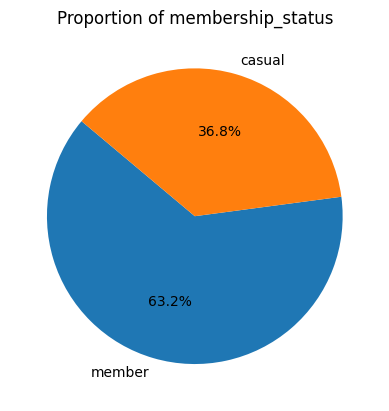

In [22]:
generate_pie(cyclistic_past_year, 'membership_status')


### Distribution of Ride Frequencies Throughout the Year

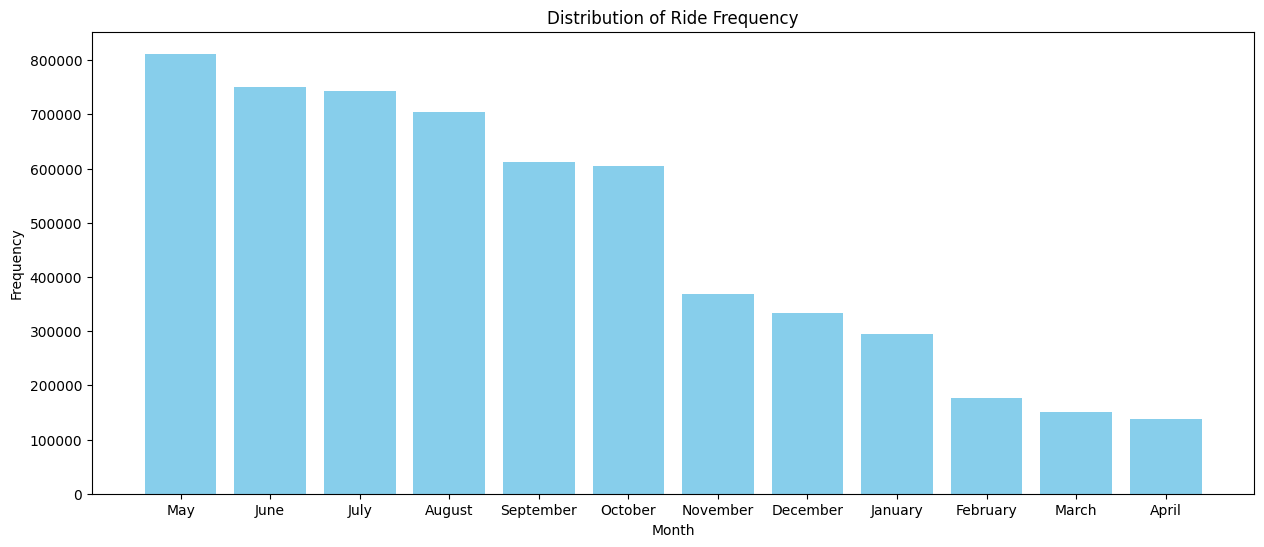

In [23]:
values = cyclistic_past_year['month'].value_counts()

plt.figure(figsize=(15, 6))

plt.bar(cyclistic_past_year['month'].unique(), values, color='skyblue')

plt.xticks(values.index, values.index)  

# Add titles and labels
plt.title('Distribution of Ride Frequency')
plt.xlabel('Month')
plt.ylabel('Frequency')

# Show the plot
plt.show()

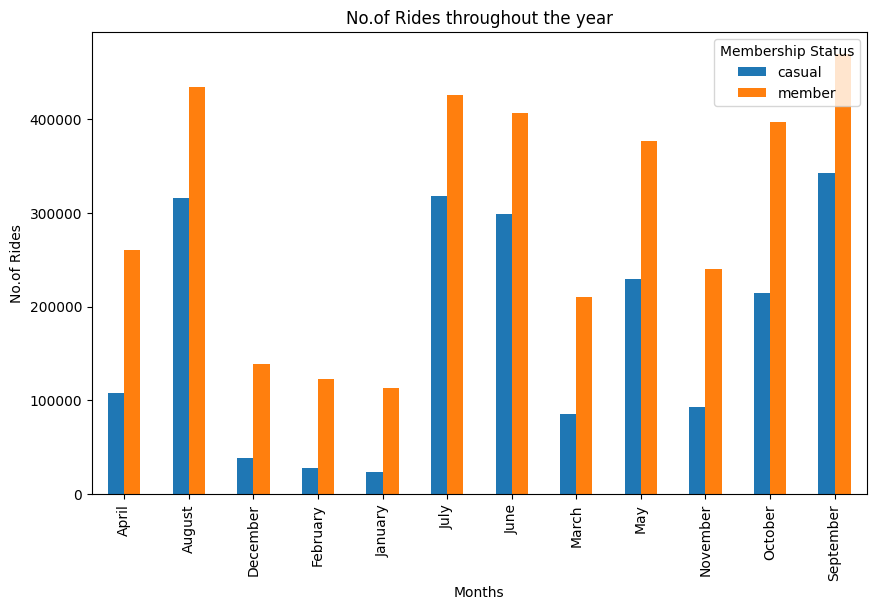

In [24]:
### --- Distribution of Ride Frequencies, for Casuals and Members ---
plot_pivot_table(data=cyclistic_past_year, index='month', columns='membership_status', aggfunc='size', 
                 title='No.of Rides throughout the year', xlabel='Months', ylabel='No.of Rides', legend_title='Membership Status')

### Right Skewedness of Ride Lengths and Ride Distances

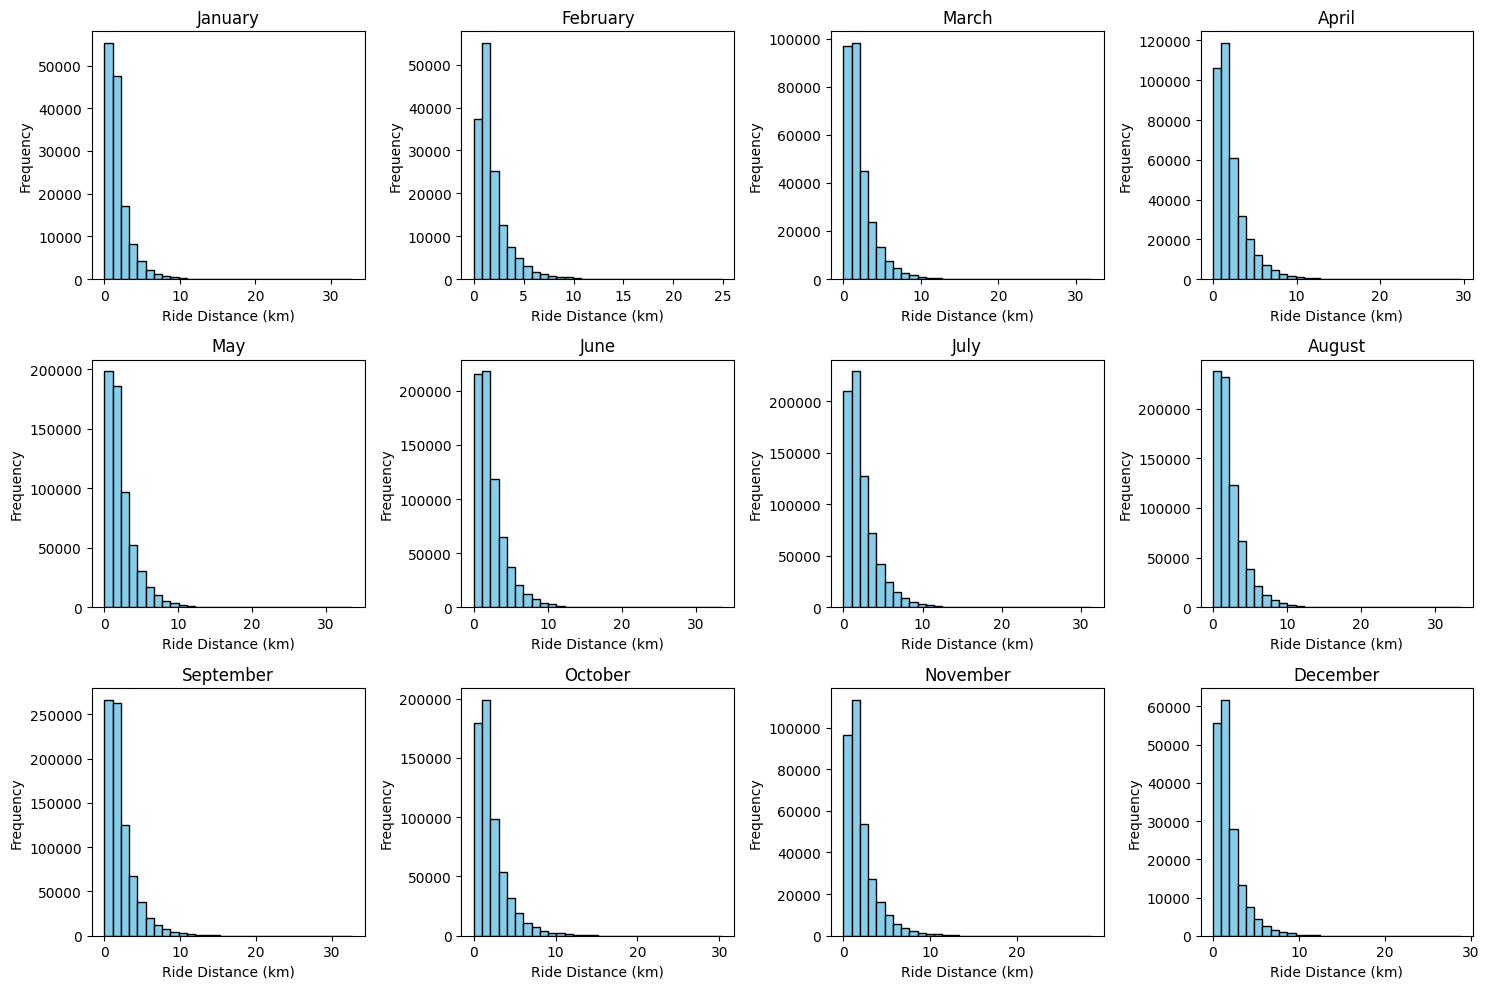

In [25]:
# --- List of months --- 
months = ['January', 'February', 'March', 'April', 'May', 'June', 
          'July', 'August', 'September', 'October', 'November', 'December']

# --- Create a 3x4 grid of subplots --- 
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
axes = axes.flatten() 

# --- Create a histogram for each month in a separate subplot --- 
for i, month in enumerate(months):
    month_data = cyclistic_past_year[cyclistic_past_year['month'] == month]
    axes[i].hist(month_data['ride_distance(km)'], bins=30, color='skyblue', edgecolor='black')
    axes[i].set_title(month)
    axes[i].set_xlabel('Ride Distance (km)')
    axes[i].set_ylabel('Frequency')

# --- Adjust layout to prevent overlap --- 
plt.tight_layout()

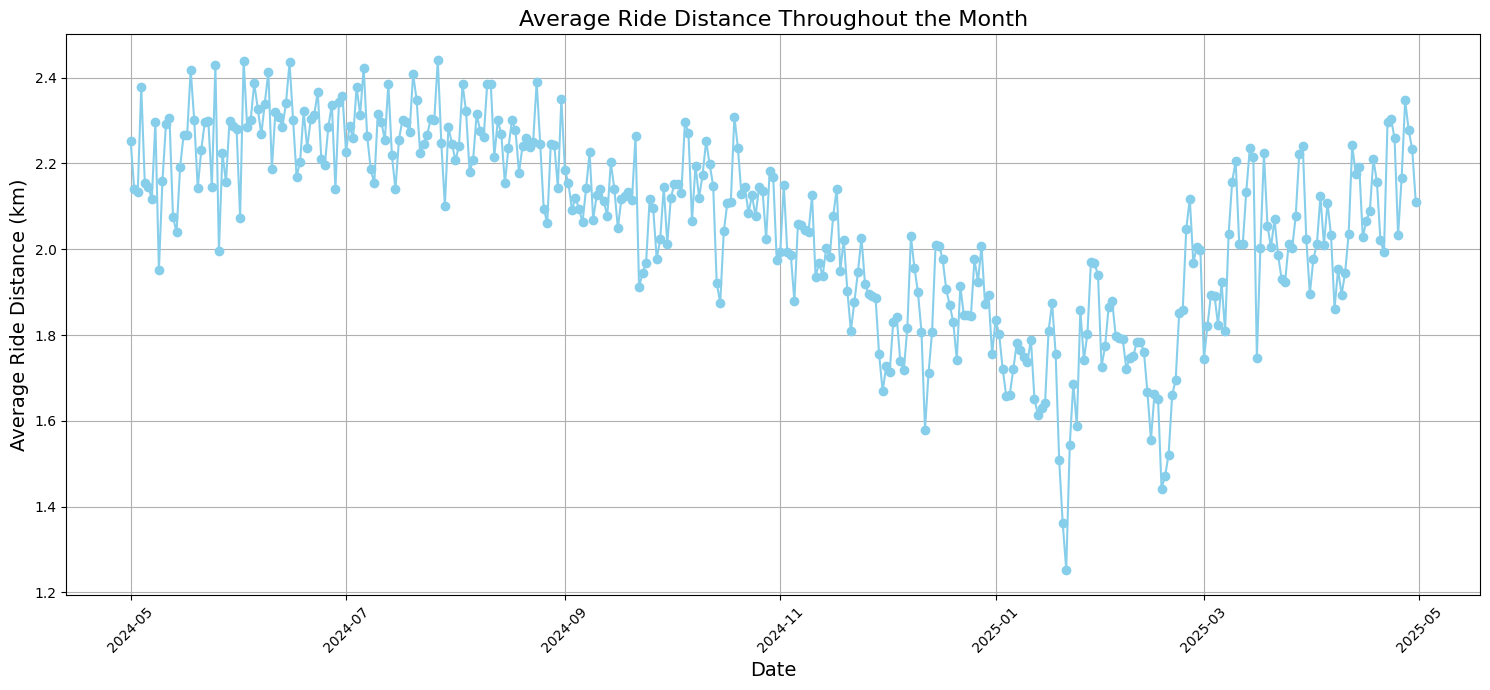

In [26]:
# Group data by day and calculate the average ride length for each day
daily_avg_ride_distance = cyclistic_past_year.groupby(cyclistic_past_year['started_at'].dt.date)['ride_distance(km)'].mean().reset_index()
daily_avg_ride_distance.columns = ['started_at', 'average_ride_distance']

# Plot the line graph
plt.figure(figsize=(15, 7))
plt.plot(daily_avg_ride_distance['started_at'], daily_avg_ride_distance['average_ride_distance'], marker='o', linestyle='-', color='skyblue')

# Add titles and labels
plt.title('Average Ride Distance Throughout the Month', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Average Ride Distance (km)', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add grid for better readability
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

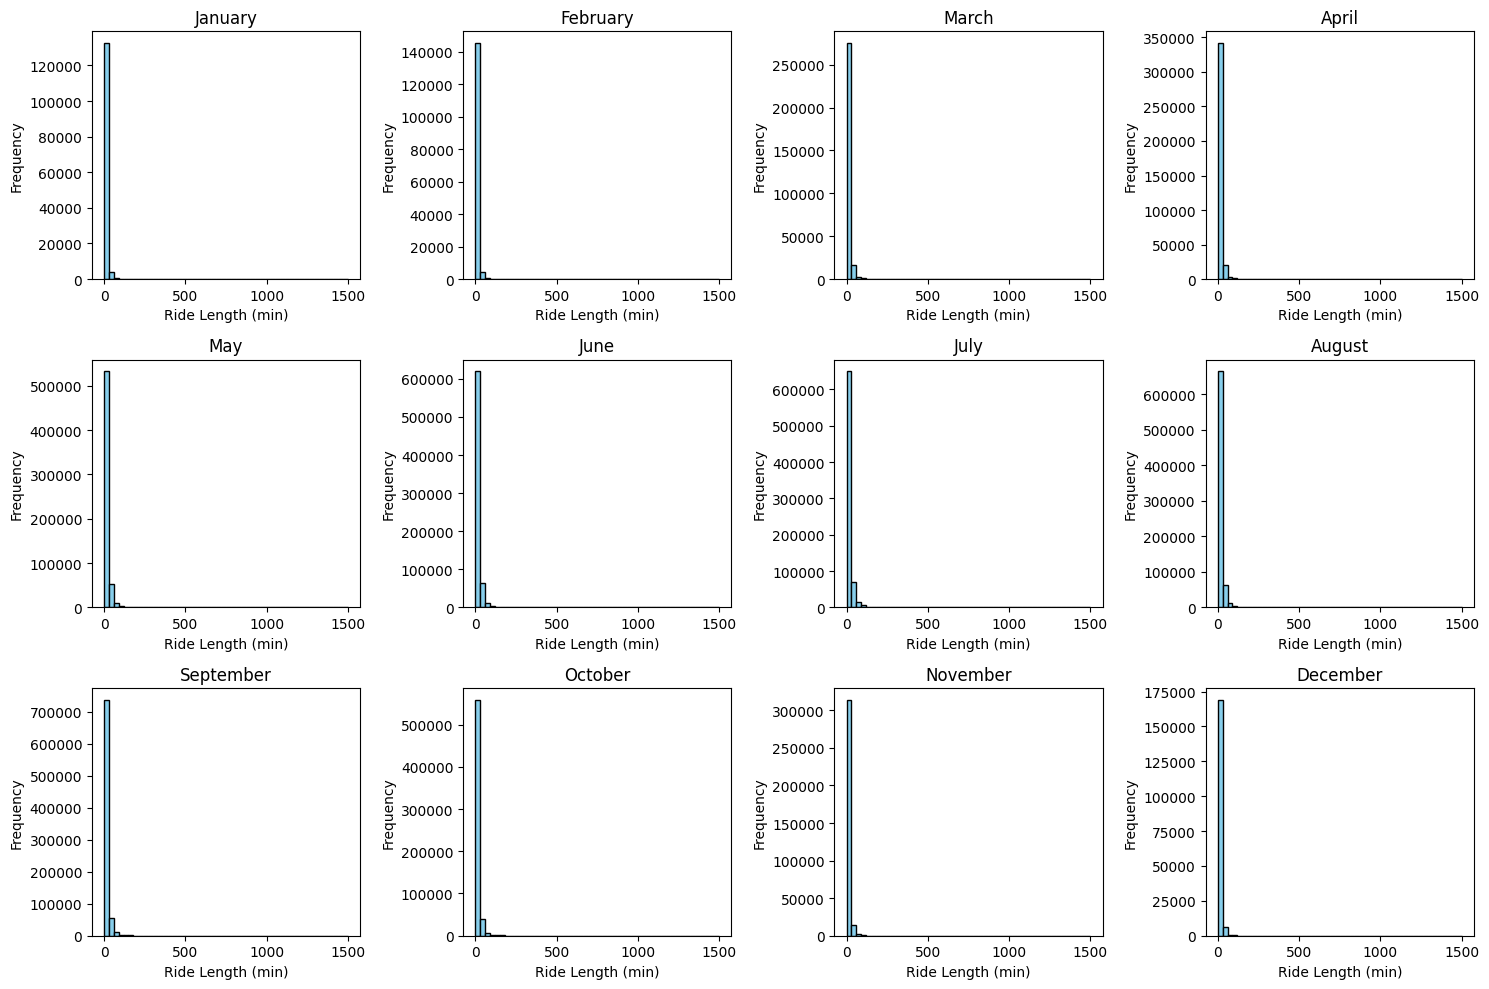

In [27]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
axes = axes.flatten()

for i, month in enumerate(months):
    month_data = cyclistic_past_year[cyclistic_past_year['month'] == month]
    axes[i].hist(month_data['ride_length(min)'], bins=50, color='skyblue', edgecolor='black')
    axes[i].set_title(month)
    axes[i].set_xlabel('Ride Length (min)')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()

### General Trends

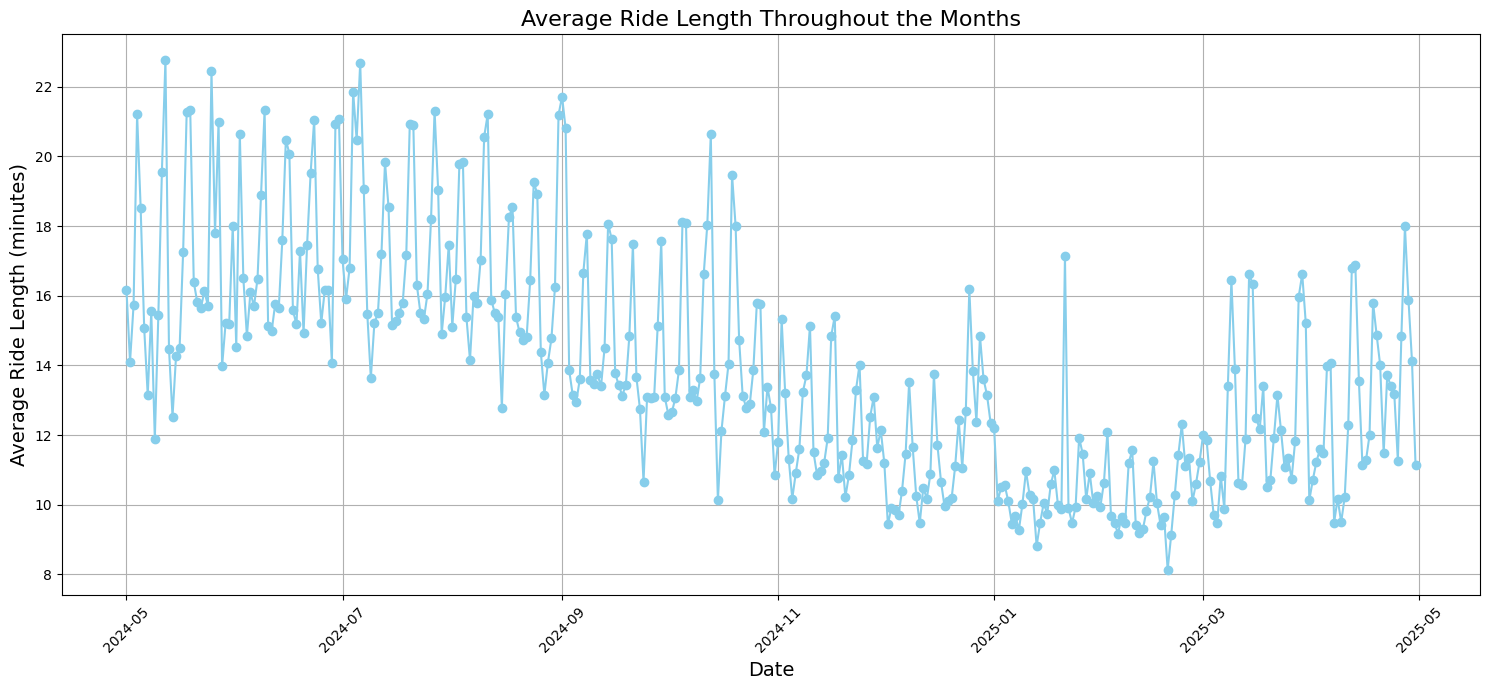

In [28]:
# Group data by day and calculate the average ride length for each day
daily_avg_ride_lengths = cyclistic_past_year.groupby(cyclistic_past_year['started_at'].dt.date)['ride_length(min)'].mean().reset_index()
daily_avg_ride_lengths.columns = ['started_at', 'average_ride_length']

# Plot the line graph
plt.figure(figsize=(15, 7))
plt.plot(daily_avg_ride_lengths['started_at'], daily_avg_ride_lengths['average_ride_length'], marker='o', linestyle='-', color='skyblue')

# Add titles and labels
plt.title('Average Ride Length Throughout the Months', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Average Ride Length (minutes)', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add grid for better readability
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

#### Heatmaps For Casual Riders VS Member Riders

In [29]:
casual_cyclistic_data = cyclistic_past_year.loc[cyclistic_past_year['membership_status'] == 'casual']

generate_heatmap(casual_cyclistic_data, 'Casual')

member_cyclistic_data = cyclistic_past_year.loc[cyclistic_past_year['membership_status'] == 'member']

generate_heatmap(member_cyclistic_data, 'Member')

#### Casual Riders Utilize Electric Scooters More Than Member Riders

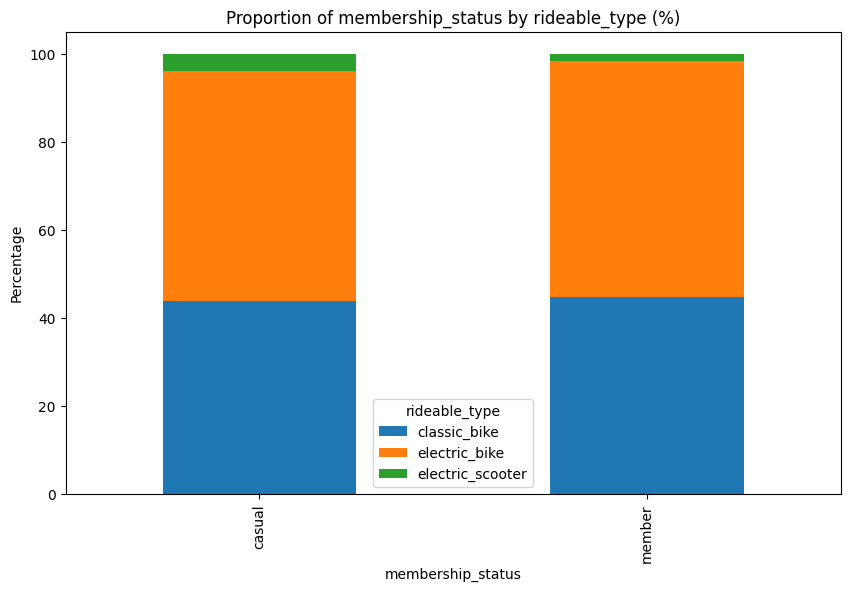

In [30]:
generate_stack_hist(cyclistic_past_year, 'membership_status', 'rideable_type')


#### Casual Riders Ride More on Fridays & Weekends

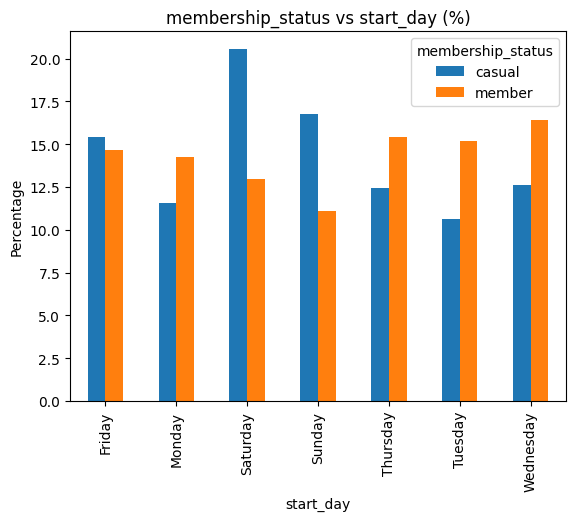

In [31]:
generate_hist_plot(cyclistic_past_year, 'membership_status', 'start_day')

#### Casual Riders Ride Longer Than Member Riders, Notably on Fridays & Weekends

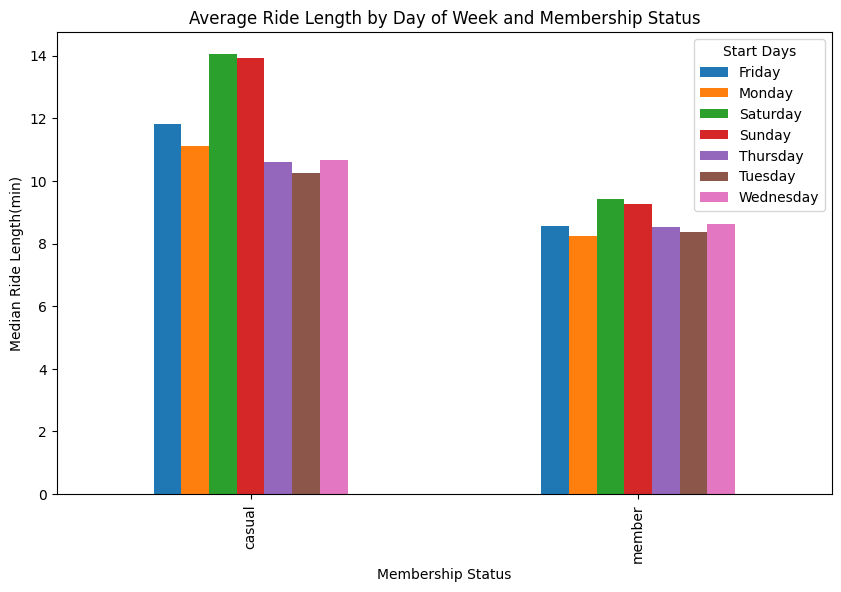

In [32]:
plot_pivot_table(cyclistic_past_year, values='ride_length(min)', index='membership_status', columns='start_day', aggfunc='median', 
                 title="Average Ride Length by Day of Week and Membership Status", 
                 xlabel='Membership Status', ylabel= 'Median Ride Length(min)', legend_title='Start Days', figsize=(10, 6))

### Seasonal Trends

In [33]:
### --- Separate Dataset Based on Seasons
spring_cyclistic_data = season_match(cyclistic_past_year, 'spring')
summer_cyclistic_data = season_match(cyclistic_past_year, 'summer')
autumn_cyclistic_data = season_match(cyclistic_past_year, 'autumn')
winter_cyclistic_data = season_match(cyclistic_past_year, 'winter')

#### General Trend of Rides Throughout The Year

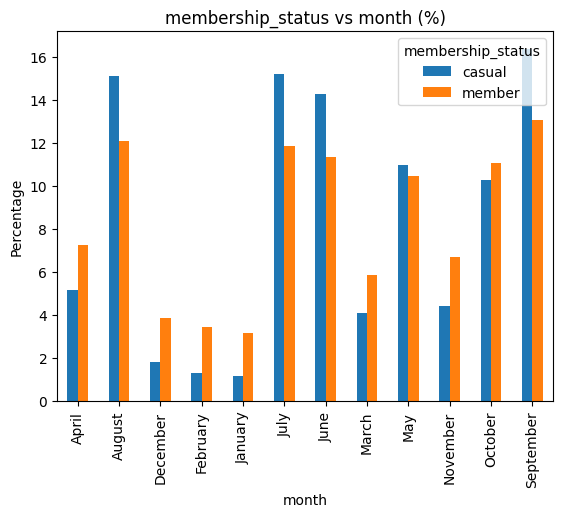

In [34]:
generate_hist_plot(cyclistic_past_year, 'membership_status', 'month')

#### Electric Scooters are especially popular in Autumn

Spring


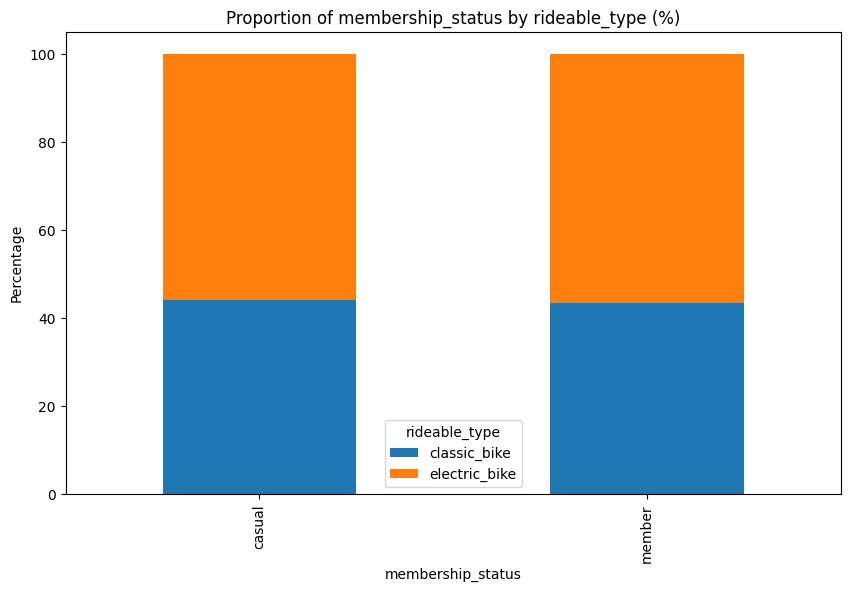

Summer


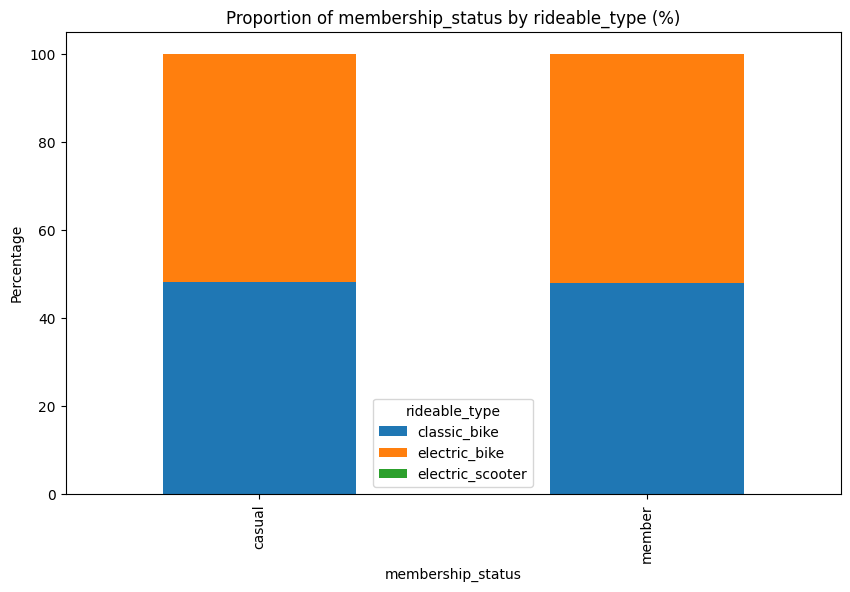

Autumn


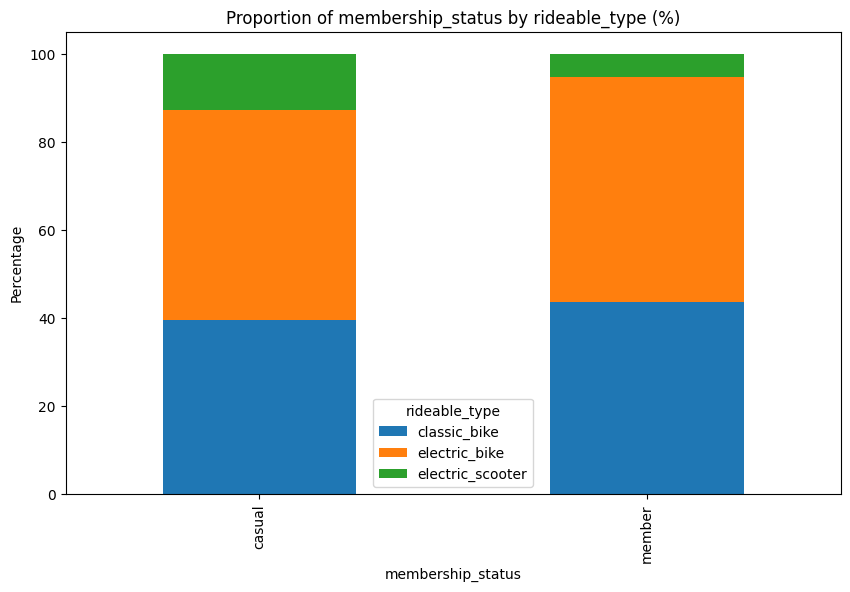

Winter


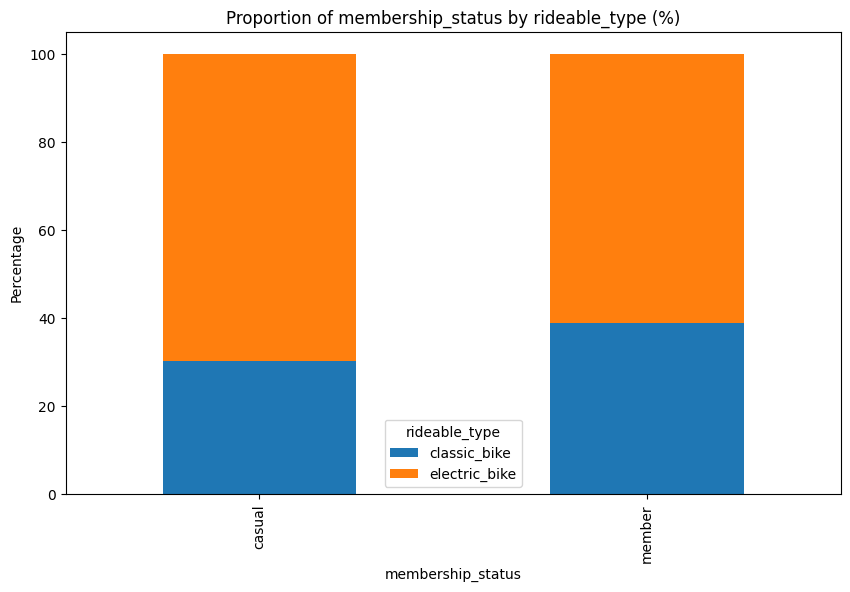

In [35]:
# --- List of Seasons --- 
seasons = {
    'Spring': spring_cyclistic_data,
    'Summer': summer_cyclistic_data,
    'Autumn': autumn_cyclistic_data,
    'Winter': winter_cyclistic_data
}

# --- Create a histogram for each Season --- 
for i, season in enumerate(seasons):
    print(season)
    generate_stack_hist(data=seasons[season], category='membership_status', subcategory='rideable_type')


#### Casual Riders enjoying riding on Fridays, and the Weekends

start_day             Friday     Monday   Saturday     Sunday   Thursday  \
membership_status                                                          
casual             17.339088  11.720704  21.192824  14.647271  11.888484   
member             15.551868  13.901653  12.944998  10.018024  15.469717   

start_day            Tuesday  Wednesday  
membership_status                        
casual             10.532045  12.679583  
member             15.241324  16.872417  


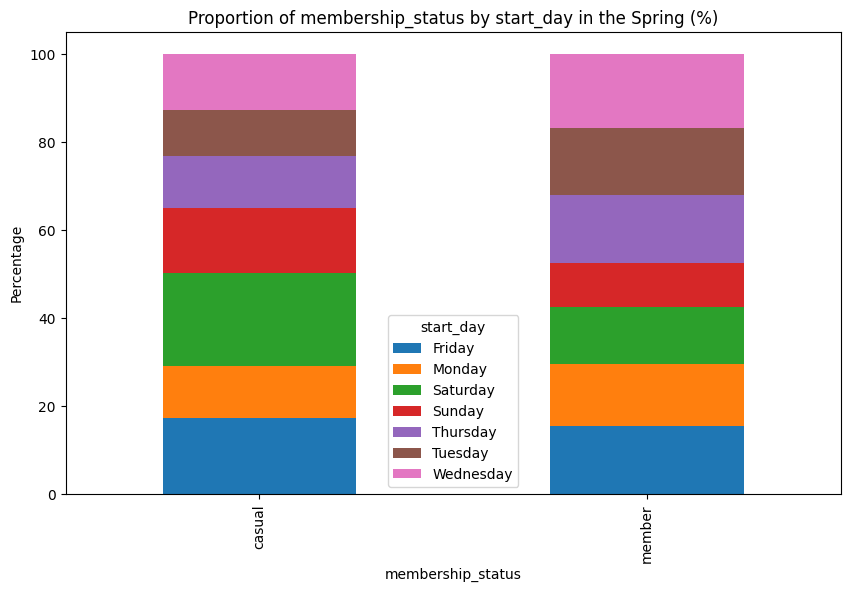

start_day             Friday     Monday   Saturday     Sunday   Thursday  \
membership_status                                                          
casual             15.180721  10.432439  21.951853  16.899661  12.487485   
member             14.457016  13.608446  14.216484  11.948080  15.015495   

start_day            Tuesday  Wednesday  
membership_status                        
casual             10.256983  12.790859  
member             14.628339  16.126140  


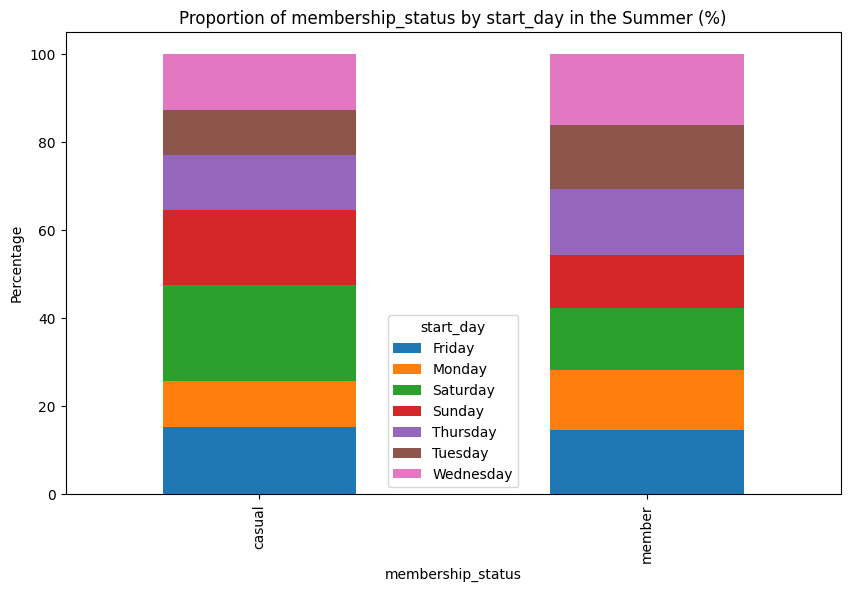

start_day             Friday     Monday   Saturday     Sunday   Thursday  \
membership_status                                                          
casual             14.576768  12.720518  18.878857  18.400471  12.524605   
member             14.388173  14.507212  12.356112  11.373364  15.525546   

start_day            Tuesday  Wednesday  
membership_status                        
casual             10.735353  12.163428  
member             15.262540  16.587051  


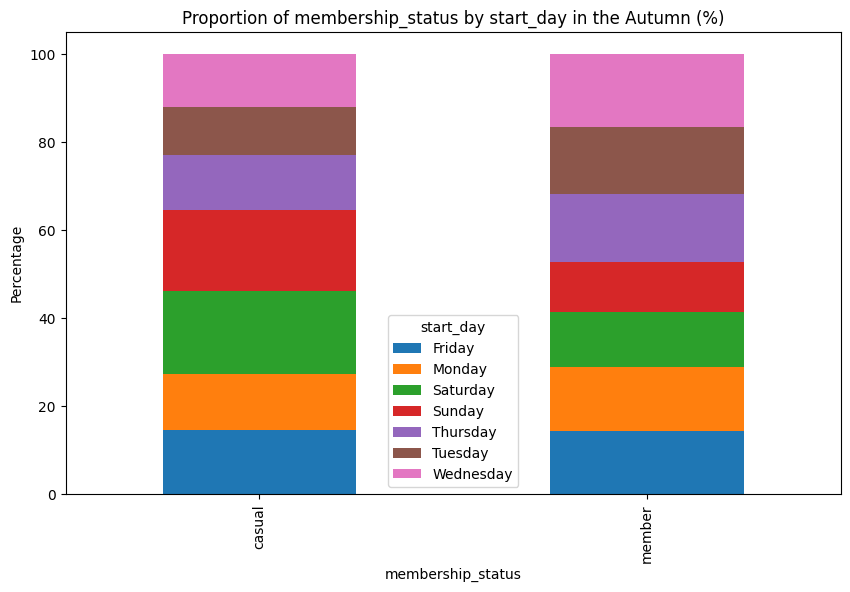

start_day             Friday     Monday   Saturday     Sunday   Thursday  \
membership_status                                                          
casual             14.607206  14.495521  15.184614  13.549554  14.562532   
member             14.150393  16.327417  10.652708   9.994643  16.358868   

start_day            Tuesday  Wednesday  
membership_status                        
casual             13.775157  13.825415  
member             16.722683  15.793289  


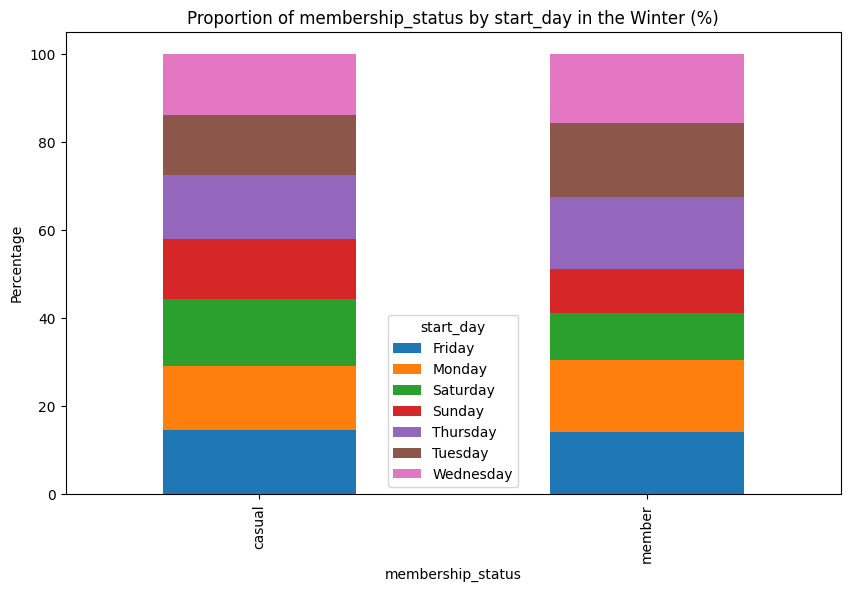

In [36]:
### --- Generate Stacked Bar Charts For Each Season, To Identify Riding Trend Across The Week ---
for i, season in enumerate(seasons):
    generate_prop_plot(data=seasons[season], cat1='membership_status', cat2='start_day', event=f'{season}')

#### Casual Riders Ride Longer Than Member Riders Throughout The Year, Peaking From 10:00 to 15:00

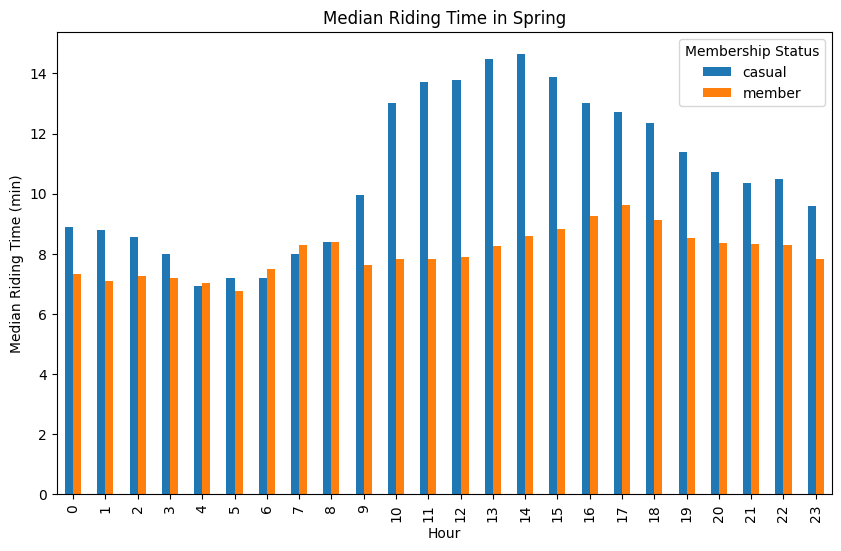

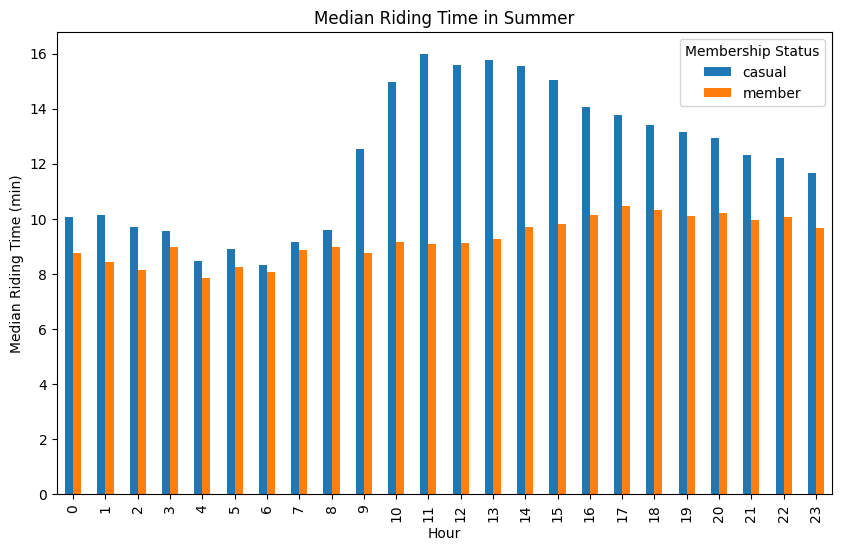

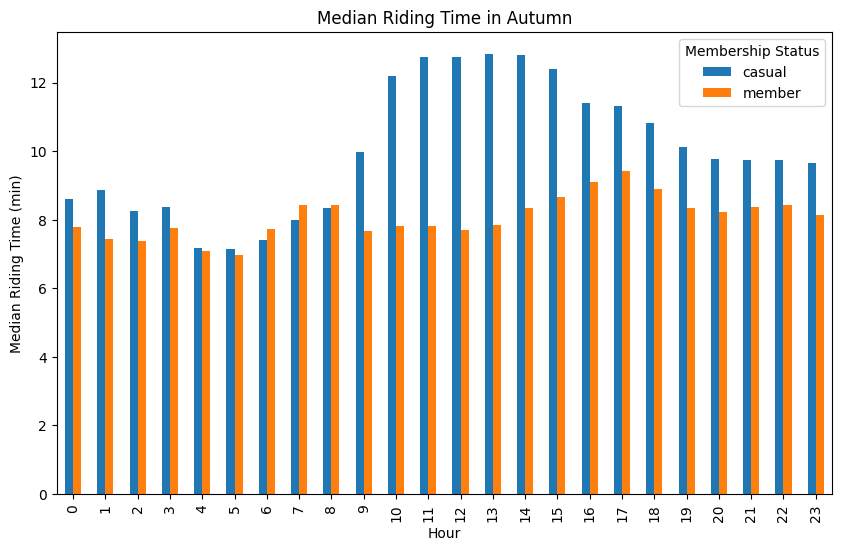

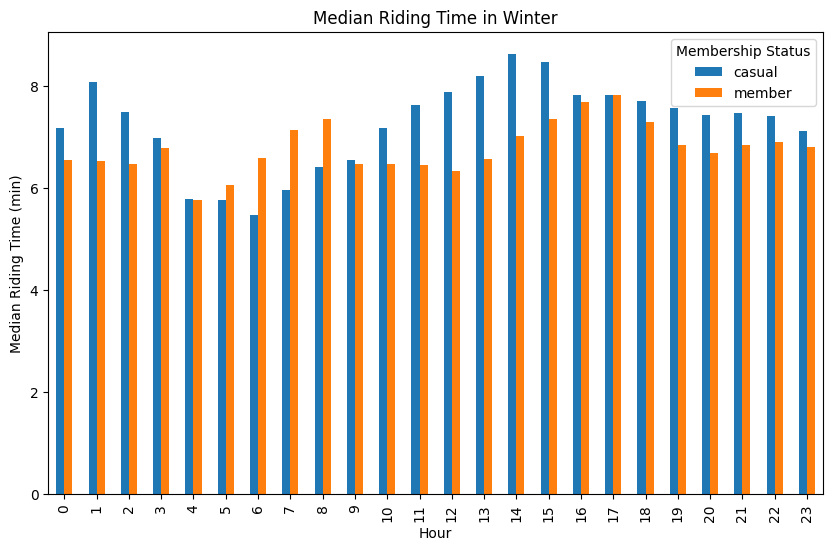

In [37]:
### --- Generate Bar Charts For Each Season To Observe Trend of Riding Times ----
for i, season in enumerate(seasons):
    plot_pivot_table(data=seasons[season], index='start_hour', columns='membership_status', aggfunc='median', values='ride_length(min)', 
                 title=f'Median Riding Time in {season}', xlabel='Hour', ylabel='Median Riding Time (min)', legend_title='Membership Status')

### Rush Hour Analysis

In [38]:
### --- Extract Datasets of Respective Rush Hours ---
morning_rush_hours = [7, 8, 9]
morning_rush_data = cyclistic_past_year.loc[cyclistic_past_year['start_hour'].isin(morning_rush_hours)]

midday_rush_hours = [12,13,14]
midday_rush_data = cyclistic_past_year.loc[cyclistic_past_year['start_hour'].isin(midday_rush_hours)]

evening_rush_hours = [16, 17, 18]
evening_rush_data = cyclistic_past_year.loc[cyclistic_past_year['start_hour'].isin(evening_rush_hours)]

rush_hours = {
    'Morning': morning_rush_data,
    'Mid-day': midday_rush_data,
    'Evening': evening_rush_data
}

#### Electric Scooters Relatively More Popular Amongst Casual Riders, Throughout the Day

rideable_type      classic_bike  electric_bike  electric_scooter
membership_status                                               
casual                40.767264      54.469538          4.763197
member                45.677780      52.679704          1.642517


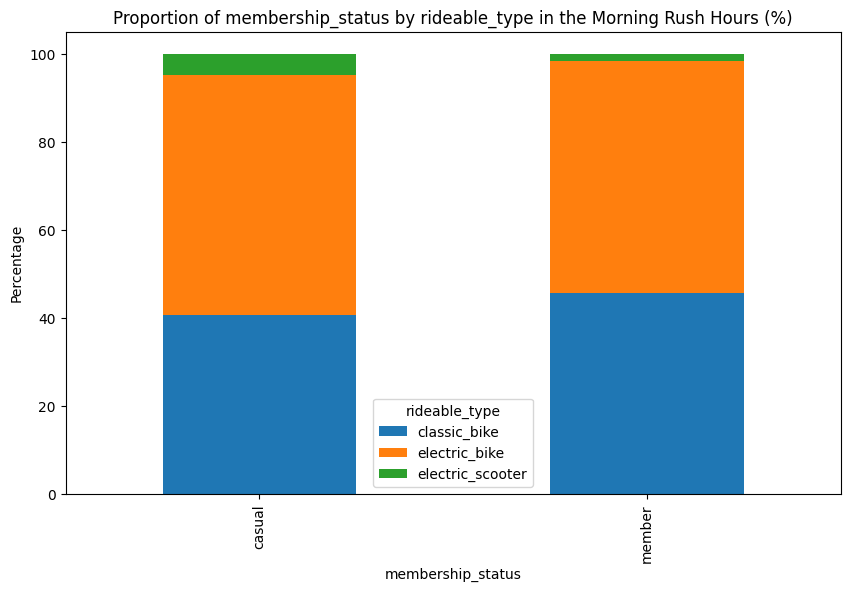

rideable_type      classic_bike  electric_bike  electric_scooter
membership_status                                               
casual                47.440909      49.044561          3.514531
member                45.607700      52.910082          1.482219


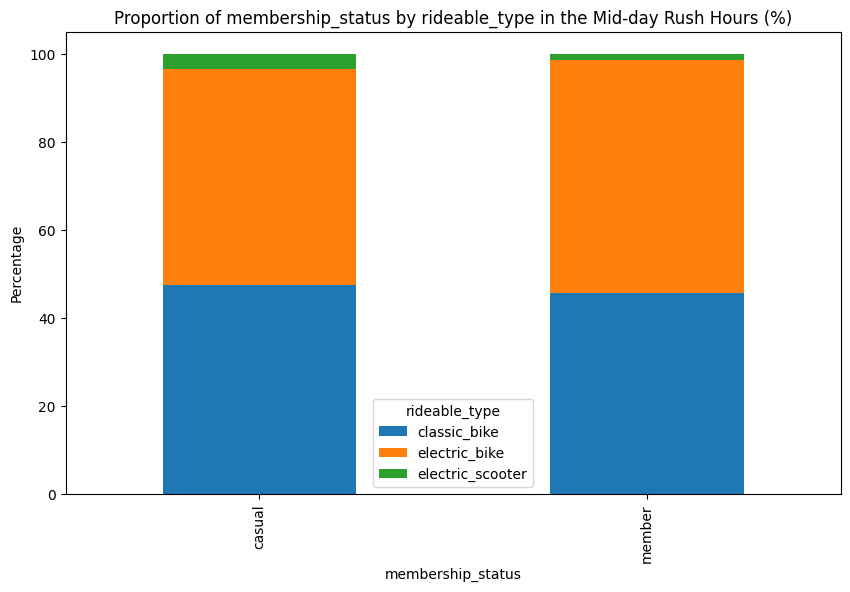

rideable_type      classic_bike  electric_bike  electric_scooter
membership_status                                               
casual                44.169383      51.709991          4.120627
member                45.446883      52.913715          1.639403


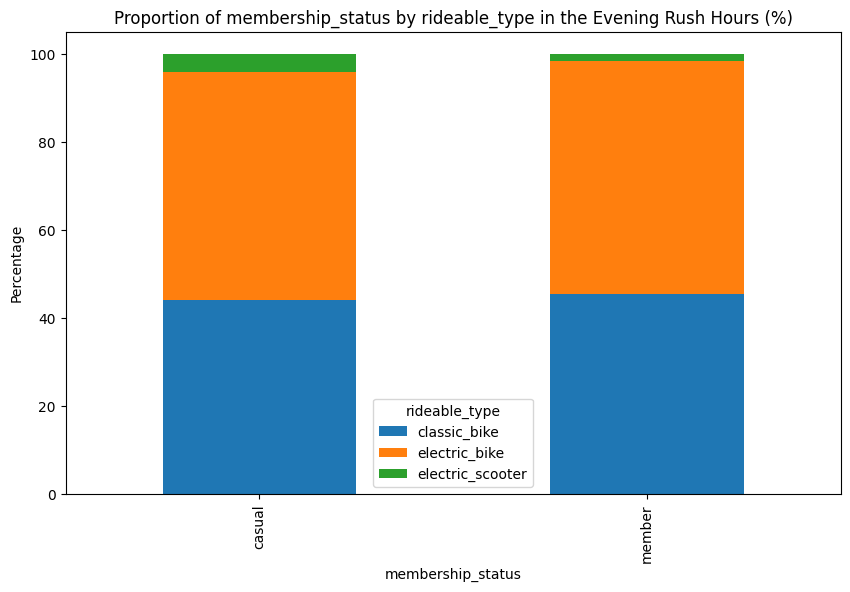

In [39]:
### --- Generate Stacked Bar Chart For Each Rush Hour, To Identify Trend on Rideable Types ---
for i, hour in enumerate(rush_hours):
    generate_prop_plot(data=rush_hours[hour], cat1='membership_status', cat2='rideable_type', event=f'{hour} Rush Hours')

#### Casual Riders Ride Significantly Longer After 09:00 Compared To Member Riders

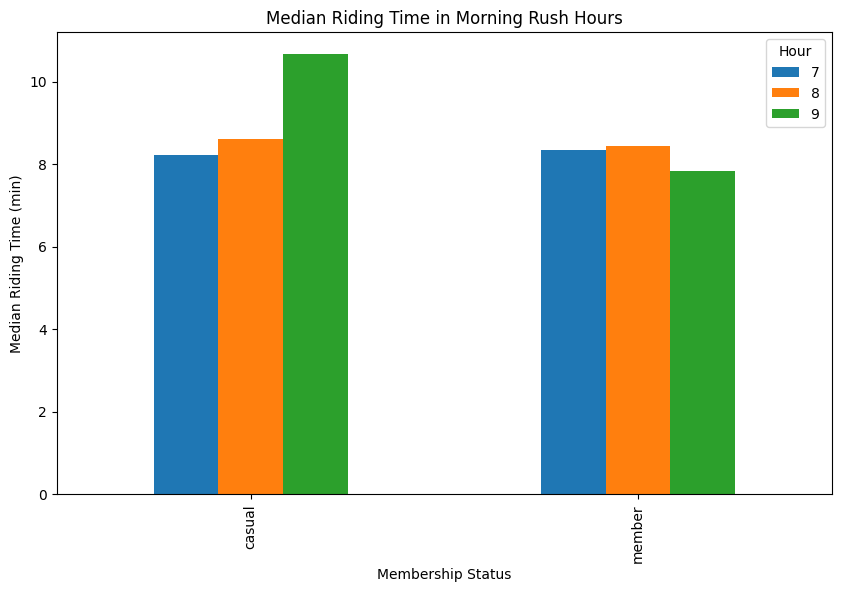

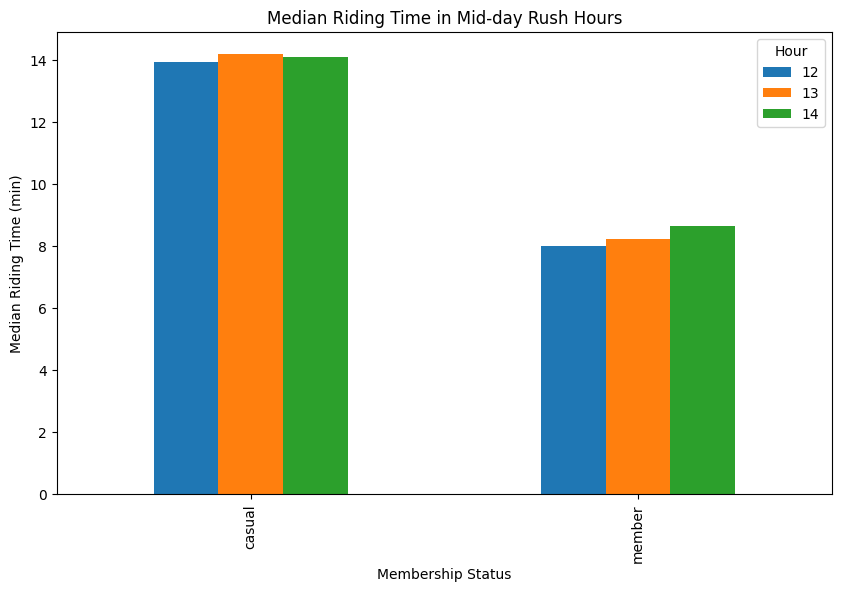

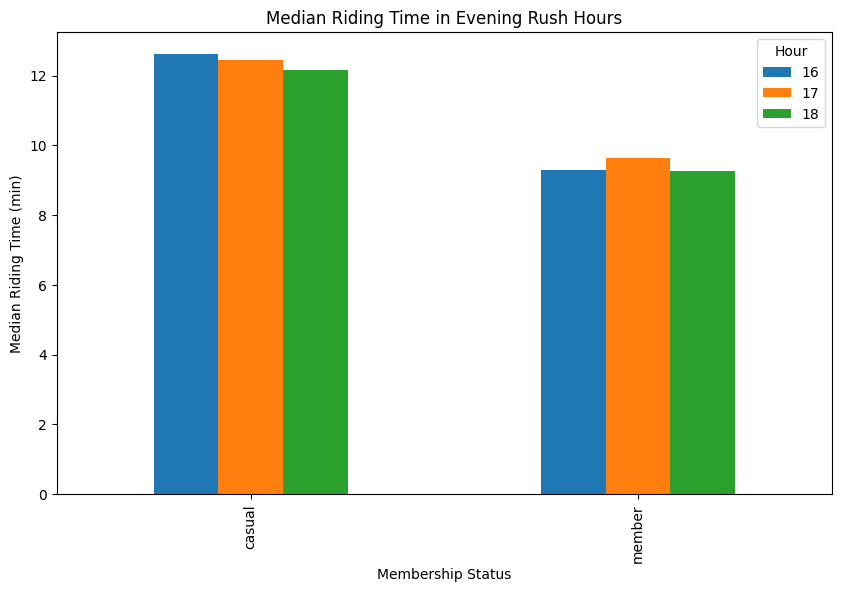

In [40]:
### --- Generate Stacked Bar Chart For Each Rush Hour, To Identify Trend on Riding Times ---
for i, hour in enumerate(rush_hours):
    plot_pivot_table(data=rush_hours[hour], index='membership_status', columns='start_hour', aggfunc='median', values='ride_length(min)', 
                 title=f'Median Riding Time in {hour} Rush Hours', xlabel='Membership Status', ylabel='Median Riding Time (min)', legend_title='Hour')